In [1]:
import sys
sys.path.insert(0, '..')
from pathlib import Path

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

from common.methods import dms_to_dd
from common.port_matcher import PortMatcher

In [2]:
folder = Path("../data/ais")

df_ais = pd.concat([pd.read_csv(file) for file in folder.glob("*01.csv")], ignore_index=True)
# Filter for vessel_type 70-79 (cargo ships)
df_cargo = df_ais[df_ais['vessel_type'].between(70, 79)]

# Read ports data
df_ports = pd.read_csv("../data/ports/ports.csv")

In [3]:
# Apply conversion to decimal degrees for latitude and longitude
df_ports['lat_dd'] = df_ports['latitude'].apply(dms_to_dd)
df_ports['lon_dd'] = df_ports['longitude'].apply(dms_to_dd)

# Create geometry column
df_ports['geometry'] = df_ports.apply(lambda row: Point(row['lon_dd'], row['lat_dd']), axis=1)

# Convert ports data to GeoDataFrame
gdf_ports = gpd.GeoDataFrame(df_ports, geometry='geometry', crs='EPSG:4326')

In [4]:
# Create PortMatcher instance
matcher = PortMatcher(gdf_ports)

# Match AIS data to ports
gdf_ais = matcher.match(df_ais)

In [5]:
# Create PortMatcher instance with a radius of 5 nautical miles
matcher_5nm = PortMatcher(gdf_ports, radius_nm=5)

# Match AIS data to ports
gdf_ais_5nm = matcher.match(df_ais)

In [6]:
print(gdf_ais.head())
print(gdf_ais_5nm.head())

        mmsi     portName
1  367733950    Anacortes
4  368050000        Essex
6  367309210       Gretna
6  367309210  New Orleans
8  366745490   Long Beach
        mmsi     portName
1  367733950    Anacortes
4  368050000        Essex
6  367309210       Gretna
6  367309210  New Orleans
8  366745490   Long Beach


In [7]:
ports_with_counts = matcher.add_port_call_counts(gdf_ais)
ports_with_counts_5nm = matcher_5nm.add_port_call_counts(gdf_ais_5nm)

Ports with call counts (10 NM radius):
            portName  port_call_count
527          Seattle              477
123         Creosote              387
428  Port Everglades              373
642          Winslow              322
44           Baytown              262
Ports with call counts (5 NM radius):
            portName  port_call_count
527          Seattle              477
123         Creosote              387
428  Port Everglades              373
642          Winslow              322
44           Baytown              262


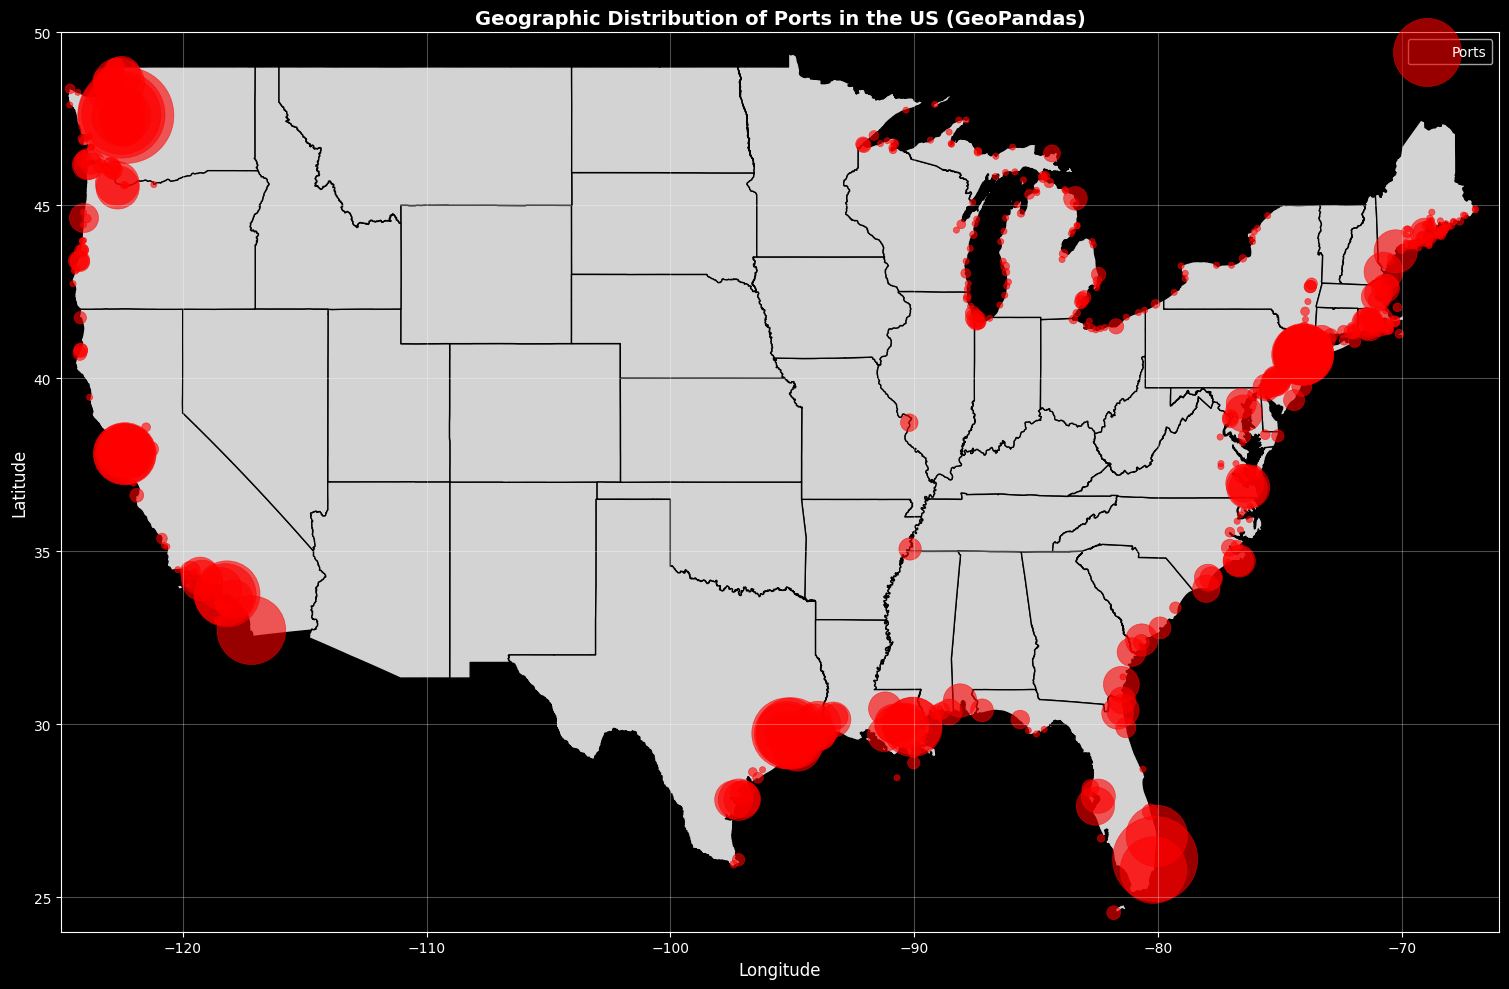

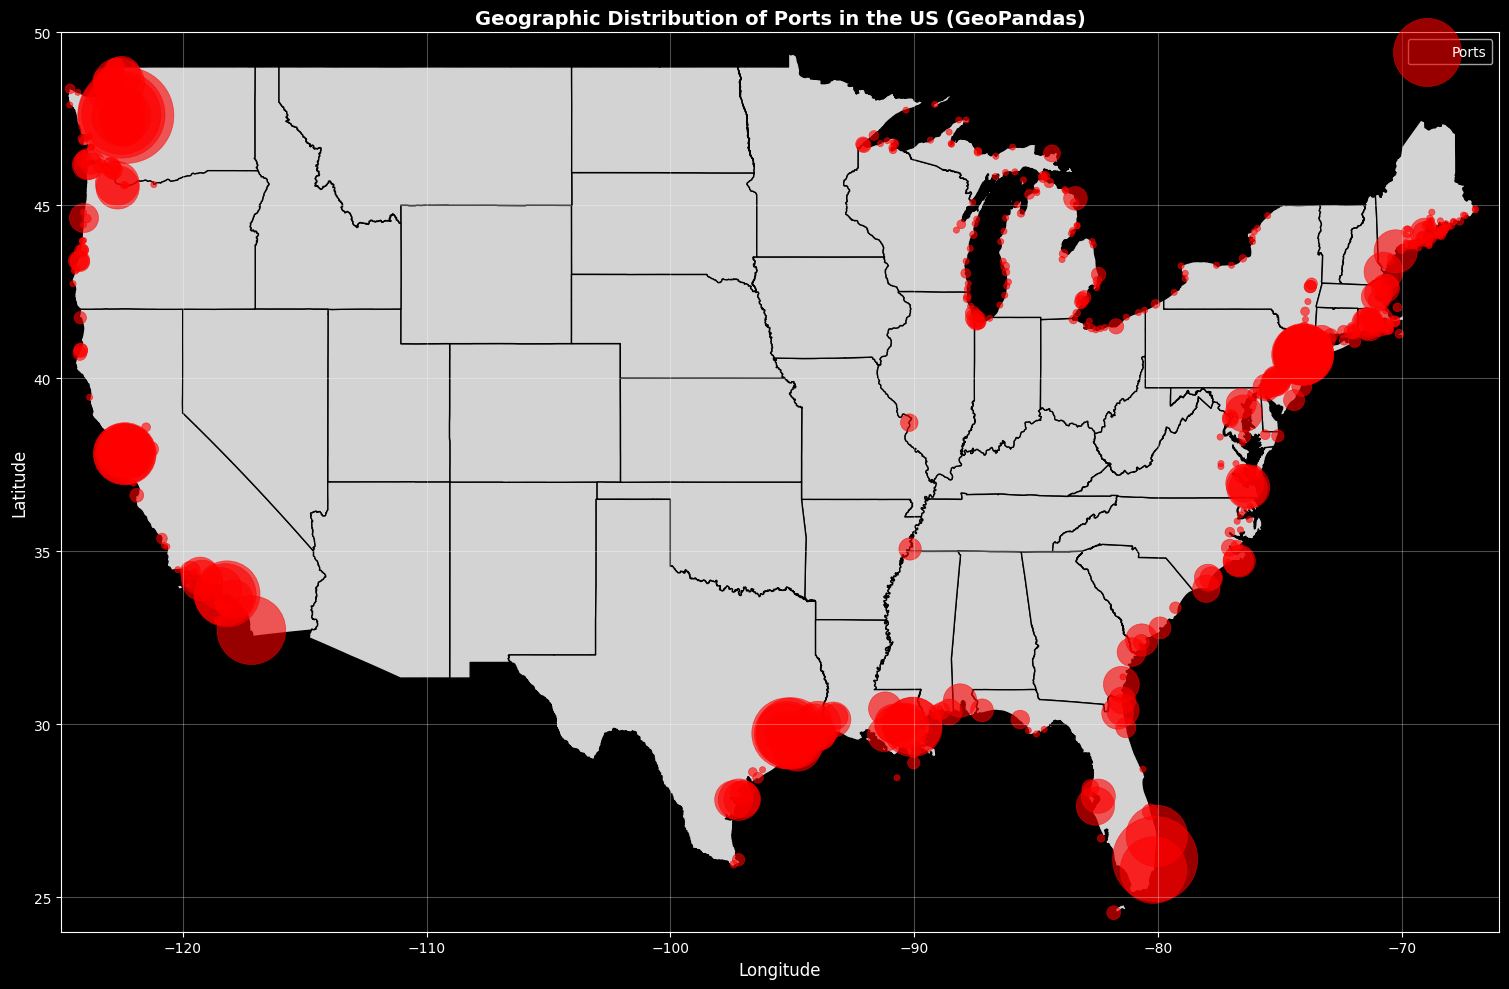

In [8]:
# Head of the ports with call counts
print("Ports with call counts (10 NM radius):")
print(ports_with_counts[['portName', 'port_call_count']].sort_values(by="port_call_count", ascending=False).head())
print("Ports with call counts (5 NM radius):")
print(ports_with_counts_5nm[['portName', 'port_call_count']].sort_values(by="port_call_count", ascending=False).head())

# Visualize port calls
matcher.visualize_port_calls()
matcher_5nm.visualize_port_calls()

In [9]:
# Visualize port calls using folium
matcher.visualize_port_calls_folium()